In [1]:
import numpy as np
import pandas as pd
import json
import random
import warnings
warnings.filterwarnings('ignore')


# get customer demand and location data
n = 50
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan.json')
data = json.load(f)
df = pd.DataFrame(data)
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand

###QLearning
qdefault = 0

In [2]:
miu = 0.05
diskon = 0.9

def bestq(qtable, node, currentNode):
    nextNode = currentNode['next']
    if len(nextNode) == 0:
        return savingNode(distance,node,currentNode['lastval'])
    nextNodeQ = qtable.loc[nextNode]
    maxQ = nextNodeQ['Q'].max()
    result = nextNodeQ[nextNodeQ['Q'] == nextNodeQ['Q'].max()]
    if(len(result) == 1):        
        return getItem(result,0)['lastval']
    else:
        return savingNode(distance,node,currentNode['lastval'])

def bestq_backup(qtable, node, currentNode):
    nextNode = currentNode['next']
    if len(nextNode) == 0:
        return randomq(node)
    nextNodeQ = qtable.loc[nextNode]
    maxQ = nextNodeQ['Q'].max()
    result = nextNodeQ[nextNodeQ['Q'] == nextNodeQ['Q'].max()]
    if maxQ == 0:
        # random semua value
        return randomq(node)
    elif(len(result) == 1):        
        return getItem(result,0)['lastval']
    else:
        return savingNode(distance,node,currentNode['lastval'])
#         rnd = random.randint(0,len(result)-1)
#         return getItem(result,rnd)['lastval']


def maxq(qtable, nextId):
    nextNode = getItem(qtable,nextId)['next']
    if len(nextNode) == 0:
        return 0
    nextNodeQ = qtable.loc[nextNode]
    maxQ = nextNodeQ['Q'].max()
    return maxQ

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total    
    
def randomq(node):
    result = random.randint(0,len(node)-1)
    return node[result]

def randomNode(qtable, node, currentNode):
    nextNode = currentNode['next']
    if len(nextNode) == 0:
        return randomq(node)
    nextNodeQ = qtable.loc[nextNode]
    rnd = random.randint(0,len(nextNodeQ)-1)
    val = getItem(nextNodeQ,rnd)['lastval']    
    if len(nextNode) == 1 and val == 0:
        return savingNode(distance,node,currentNode['lastval'])
    else:
        while val < 1:
            rnd = random.randint(0,len(nextNodeQ)-1)
            val = getItem(nextNodeQ,rnd)['lastval'] 
    return val

def loadQ():
    f = open('node_'+str(n)+'.json')
    data = json.load(f)
    df = pd.DataFrame(data)
    return df

def saveQ(df):    
    out = df.to_dict('records')
    with open('node_'+str(n)+'.json', 'w') as outfile:
        json.dump(out, outfile)

def updateQ(qtable, currentNode, nextId, reward):
    i = currentNode['id']
    MaxQ = maxq(qtable,nextId)
    newQ = currentNode['Q'] + ( miu * ( reward + ( diskon * MaxQ ) - currentNode['Q'] ) )
    return newQ
    
def addNewNode(qtable,path,i,rw):
    id = len(qtable)
    if rw == 0:
        rw = qdefault
    qrow = {
        "id":id,
        "path":path.copy(),
        "Q":rw,
        "next":[],
        "lastval":i
    }
    qtable = qtable.append(qrow, ignore_index=True)
#     saveQ(qtable)
    return qtable,id

def getNodeId(qtable,currentNode,value):
    nextNode = currentNode['next']
    for i in nextNode :
        if(qtable.loc[i,'lastval'] == value):
            return i
    return -1

def updateNode(qtable, currentNode):
    indexNode = currentNode['id']
    qtable.loc[indexNode] = list(currentNode.values())
#     saveQ(qtable)
    return qtable
    
def getItem(df,index):
    return df.iloc[[index]].to_dict('records')[0]

def savingNode(data_distance,node, i):
    max_saving = 0
    res = 0
    if i == 0:
        [i,j] = savingFirst(data_distance,node)
        res = i
    else:
        for j in range(1,n+1):
            if (j in node) and (j != i):
                S1 = data_distance[i][0] + data_distance[0][j] - data_distance[i][j]
                if(max_saving<S1):
                    max_saving = S1
                    res = j       
    return res

def savingFirst(data_distance,node):
    max_saving = 0
    res = [0,0]
    for i in range(1,n+1):
        for j in range(1,n+1):
            if (j in node) and (i in node) and (j != i):
                S1 = data_distance[i][0] + data_distance[0][j] - data_distance[i][j]
                if(max_saving<S1):
                    max_saving = S1
                    res = [i,j]
    return res

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def getReward(total):
    DA = np.loadtxt('DA_'+str(n)+'.txt')
    if DA == 0:
        DA = total
    if(DA>=total):
        r = 1
        DA = total
    else:
        r = 0
    np.savetxt('DA_'+str(n)+'.txt', np.array([DA]))
    return r

def action(qtable, currentNode, nodes, routes, path, capacity, nextCustomer, reward):
   
    ## Chek node Tujuan
    routes.append([currentNode['lastval'],nextCustomer])
    path.append(str(nextCustomer))
    nextId = getNodeId(qtable,currentNode,nextCustomer)
    if(nextId == -1):
        qtable,nextId = addNewNode(qtable,path,nextCustomer,reward)
        currentNode['next'].append(nextId)
    ## Delete Nodes selain 0
    if(nextCustomer > 0):
        getndex = np.where(nodes == nextCustomer)[0]
        nodes = np.delete(nodes, [getndex])    
    ## Update Qvalue
    Qval = updateQ(qtable,currentNode,nextId,reward)
    ## Update Nodes
    currentNode['Q'] = Qval
    Q = updateNode(qtable,currentNode)
    capacity -= demand[j]
    currentNode = getItem(qtable,nextId)
    return qtable,currentNode,nodes,routes,path,capacity

In [3]:
DA = np.array([0])
np.savetxt('DA_'+str(n)+'.txt',DA)
Q = [{
        "id":0,
        "path":[0],
        "Q":qdefault,
        "next":[],
        "lastval":0
    }]
df = pd.DataFrame(Q)
saveQ(df)

In [4]:
MaxEpisode = 301
Training = 250
episode = 0
cek1 = []
cek2 = []
best_route=[]
best_path=[]
best_distance=0
epsilon = 0.1
hacklearn = [20,10]
c_hacklearn = 0
cek = True
###Menghitung Waktu
import time
start_timer = time.time()

while(episode < MaxEpisode):
    Q = loadQ()
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    route = 1
    routes = []
    path = ['0']
    croute = []
    i = 0
    total_dis = 0
    currentNode = getItem(Q,0)
    hack = 1
#     [i,j] = savingFirst(distance,nodes)
#     Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, i, 0)    
#     Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, j, 0)
    while(len(nodes)>0):
        greed = random.random()
        i = currentNode['lastval']
        if cek == False :
            j = int(best_path[hack])
            if(j == 0):
                hack+=1
                j = int(best_path[hack])
        elif(len(nodes) == 1):
            j = nodes[0]            
        elif greed < epsilon :
            #Exploration Move
            if episode==MaxEpisode-1:
                j = bestq(Q, nodes, currentNode)
            elif episode > Training :
                j = randomNode(Q, nodes, currentNode)
            else:
                j = randomq(nodes)
        else:
            #Exploitation Move
            if episode > Training :
                j = bestq(Q, nodes, currentNode)
            else:
                j = savingNode(distance,nodes,i)
#                 if i > 0 :
#                 else:
#                     [i,j] = savingFirst(distance,nodes)
#                     Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, i, 0)        
        if (capacity - demand[j] > 0) and (j > 0) :    
            Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, j, 0)
            hack+=1
        else:
            Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, 0, 0)
            croute.append(routes)
            total_dis+=countDistance(routes)
            route += 1
            routes = []
            capacity = vehicle_capacity
        if(len(nodes) == 0):
            croute.append(routes)
            total_dis+=countDistance(routes)
            route += 1
            reward = getReward(total_dis)
            Q,currentNode,nodes,routes,path,capacity = action(Q,currentNode,nodes,routes,path,capacity, 0, reward)
            saveQ(Q)
    cek1.append(episode)
    cek2.append(total_dis)
    print("Episode : "+str(episode))
    print("Hack : "+str(c_hacklearn)+" "+str(cek))
    for m in range(route - 1):
        print("Rute "+str(m)+" : "+str(croute[m]))
    print("Total Distace : "+str(total_dis))
    print("-------------------------")    
    if ( best_distance == 0) or (best_distance>total_dis) :
        best_distance = total_dis
        best_route = croute
        best_path = path
    episode+=1
    c_hacklearn+=1
    if(cek):
        if(c_hacklearn == hacklearn[0]):
            cek = False
            c_hacklearn = 0
    else:
        if(c_hacklearn == hacklearn[1]):
            cek = True
            c_hacklearn = 0
        
    
###Menghitung Waktu
done_timer = time.time()
elapsed = done_timer - start_timer
print("Time : "+str(elapsed))
print("") 
print("") 
print("----------BEST ROUTE---------------") 
for m in range(len(best_route)):
    print("Rute "+str(m)+" : "+str(best_route[m]))
print("Total Distace : "+str(best_distance))

Episode : 0
Hack : 0 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 8], [8, 4], [4, 39], [39, 15], [15, 14], [14, 0]]
Rute 2 : [[0, 38], [38, 37], [37, 40], [40, 3], [3, 18], [18, 19], [19, 20], [20, 17], [17, 0]]
Rute 3 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 30], [30, 31], [31, 45], [45, 0]]
Rute 5 : [[0, 7], [7, 13], [13, 32], [32, 6], [6, 27], [27, 26], [26, 12], [12, 0]]
Rute 6 : [[0, 9], [9, 1], [1, 2], [2, 24], [24, 34], [34, 0]]
Rute 7 : [[0, 10], [10, 23], [23, 22], [22, 11], [11, 46], [46, 21], [21, 0]]
Rute 8 : [[0, 50], [50, 0]]
Total Distace : 117895.0
-------------------------
Episode : 1
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 11], [11, 1], [1, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 40], [40, 7], [7, 13], [13, 14], [14, 32], [32, 0]]
Rute 3 : [[0, 4

Episode : 12
Hack : 12 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 7], [7, 13], [13, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 1], [1, 2], [2, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 3], [3, 0]]
Rute 6 : [[0, 9], [9, 24], [24, 34], [34, 12], [12, 6], [6, 0]]
Rute 7 : [[0, 23], [23, 27], [27, 22], [22, 10], [10, 21], [21, 26], [26, 50], [50, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 117637.0
-------------------------
Episode : 13
Hack : 13 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 45], [45, 46], [46, 35], [35, 36], [36, 20], [20, 4], [4, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 14], [14, 32], [32, 7], [7, 40], [40, 0]]
Rute 3 : [[0, 44], [4

Episode : 24
Hack : 4 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 40], [40, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 6], [6, 24], [24, 9], [9, 23], [23, 0]]
Rute 7 : [[0, 10], [10, 34], [34, 12], [12, 27], [27, 11], [11, 21], [21, 26], [26, 0]]
Total Distace : 112838.0
-------------------------
Episode : 25
Hack : 5 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 1

Episode : 36
Hack : 6 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 15], [15, 14], [14, 32], [32, 7], [7, 13], [13, 16], [16, 0]]
Rute 2 : [[0, 27], [27, 34], [34, 39], [39, 37], [37, 38], [38, 40], [40, 3], [3, 8], [8, 0]]
Rute 3 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 4 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 0]]
Rute 5 : [[0, 49], [49, 4], [4, 11], [11, 1], [1, 12], [12, 0]]
Rute 6 : [[0, 18], [18, 19], [19, 20], [20, 17], [17, 9], [9, 2], [2, 0]]
Rute 7 : [[0, 50], [50, 6], [6, 22], [22, 23], [23, 24], [24, 0]]
Rute 8 : [[0, 26], [26, 10], [10, 21], [21, 0]]
Total Distace : 128601.0
-------------------------
Episode : 37
Hack : 7 True
Rute 0 : [[0, 33], [33, 41], [41, 29], [29, 43], [43, 44], [44, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 6], [6, 27], [27, 34], [34, 5], [5, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 14], [14, 32], [32, 0]]
Rute 3 : [[0, 37], [37,

Episode : 48
Hack : 18 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 13], [13, 7], [7, 14], [14, 32], [32, 6], [6, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 35], [35, 45], [45, 0]]
Rute 3 : [[0, 16], [16, 49], [49, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 4 : [[0, 37], [37, 38], [38, 46], [46, 30], [30, 31], [31, 11], [11, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 40], [40, 3], [3, 8], [8, 1], [1, 0]]
Rute 6 : [[0, 9], [9, 2], [2, 24], [24, 34], [34, 12], [12, 27], [27, 0]]
Rute 7 : [[0, 50], [50, 26], [26, 22], [22, 23], [23, 10], [10, 21], [21, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 119051.0
-------------------------
Episode : 49
Hack : 19 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 6], [6, 27], [27, 34], [34, 15], [15, 14], [14, 32], [32, 7], [7, 0]]
Rute 2 : [[0, 9], [9, 39], [39, 37], [37, 38], [38, 40], [40, 3], [3, 8], [8, 0]]
Rute 3 : [[0, 42]

Episode : 60
Hack : 0 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 7], [7, 13], [13, 14], [14, 32], [32, 0]]
Rute 3 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 21], [21, 0]]
Rute 4 : [[0, 37], [37, 38], [38, 27], [27, 34], [34, 15], [15, 40], [40, 3], [3, 22], [22, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 10], [10, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 46], [46, 45], [45, 31], [31, 30], [30, 11], [11, 0]]
Rute 7 : [[0, 9], [9, 8], [8, 24], [24, 23], [23, 12], [12, 0]]
Rute 8 : [[0, 50], [50, 26], [26, 6], [6, 0]]
Total Distace : 125673.0
-------------------------
Episode : 61
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 11], [11, 1], [1, 0]]
Rute 3 : [[0, 37], [37, 38], [3

Episode : 72
Hack : 12 True
Rute 0 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 28], [28, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 38], [38, 37], [37, 39], [39, 5], [5, 15], [15, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 3 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 40], [40, 14], [14, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 46], [46, 45], [45, 30], [30, 0]]
Rute 5 : [[0, 8], [8, 20], [20, 3], [3, 1], [1, 2], [2, 24], [24, 0]]
Rute 6 : [[0, 7], [7, 21], [21, 11], [11, 6], [6, 27], [27, 34], [34, 12], [12, 13], [13, 0]]
Rute 7 : [[0, 23], [23, 32], [32, 22], [22, 9], [9, 31], [31, 0]]
Rute 8 : [[0, 26], [26, 10], [10, 0]]
Total Distace : 116740.0
-------------------------
Episode : 73
Hack : 13 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 14], [14, 40], [40, 39], [39, 15], [15, 37], [37, 38], [38, 0]]
Rute 3 : [[0, 7],

Episode : 84
Hack : 4 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 40], [40, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 6], [6, 24], [24, 9], [9, 23], [23, 0]]
Rute 7 : [[0, 10], [10, 34], [34, 12], [12, 27], [27, 11], [11, 21], [21, 26], [26, 0]]
Total Distace : 112838.0
-------------------------
Episode : 85
Hack : 5 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 1

Episode : 96
Hack : 6 True
Rute 0 : [[0, 33], [33, 41], [41, 34], [34, 5], [5, 39], [39, 7], [7, 13], [13, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 15], [15, 0]]
Rute 3 : [[0, 1], [1, 24], [24, 3], [3, 8], [8, 18], [18, 0]]
Rute 4 : [[0, 19], [19, 20], [20, 40], [40, 14], [14, 32], [32, 25], [25, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 22], [22, 27], [27, 12], [12, 6], [6, 0]]
Rute 6 : [[0, 48], [48, 30], [30, 31], [31, 11], [11, 2], [2, 0]]
Rute 7 : [[0, 50], [50, 28], [28, 26], [26, 9], [9, 23], [23, 0]]
Rute 8 : [[0, 21], [21, 10], [10, 0]]
Total Distace : 123220.0
-------------------------
Episode : 97
Hack : 7 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 1], [1, 39], [39, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 15], [15, 0]]
Rut

Episode : 108
Hack : 18 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], [37, 50], [50, 6], [6, 27], [27, 34], [34, 7], [7, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 38], [38, 40], [40, 14], [14, 32], [32, 0]]
Rute 5 : [[0, 46], [46, 12], [12, 13], [13, 30], [30, 11], [11, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 48], [48, 45], [45, 31], [31, 3], [3, 8], [8, 0]]
Rute 7 : [[0, 9], [9, 24], [24, 23], [23, 22], [22, 0]]
Rute 8 : [[0, 26], [26, 10], [10, 21], [21, 0]]
Total Distace : 130957.0
-------------------------
Episode : 109
Hack : 19 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 34], [34, 15], [15, 0]]
Rute 2 : [[0, 43], [43, 44], [44, 48], [48, 24], [24, 1], [1, 0]]
Rute 3 : [[0, 11], [11, 2],

Episode : 120
Hack : 0 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 50], [50, 6], [6, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 48], [48, 4], [4, 39], [39, 0]]
Rute 3 : [[0, 49], [49, 16], [16, 17], [17, 18], [18, 19], [19, 0]]
Rute 4 : [[0, 27], [27, 34], [34, 15], [15, 1], [1, 2], [2, 24], [24, 3], [3, 0]]
Rute 5 : [[0, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 7], [7, 26], [26, 12], [12, 0]]
Rute 6 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 8], [8, 20], [20, 0]]
Rute 7 : [[0, 23], [23, 13], [13, 22], [22, 9], [9, 10], [10, 21], [21, 0]]
Total Distace : 129497.0
-------------------------
Episode : 121
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 48], [48, 40], [40, 18], [18, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 45], [45, 46], [46, 30], [30, 0]]
Rute 3 : [[0, 13], [13, 7], [7, 11]

Episode : 132
Hack : 12 True
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 21], [21, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 3 : [[0, 9], [9, 3], [3, 8], [8, 4], [4, 37], [37, 38], [38, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 18], [18, 19], [19, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 1], [1, 0]]
Rute 6 : [[0, 20], [20, 40], [40, 2], [2, 10], [10, 34], [34, 7], [7, 13], [13, 6], [6, 0]]
Rute 7 : [[0, 23], [23, 26], [26, 12], [12, 27], [27, 24], [24, 48], [48, 0]]
Total Distace : 112580.0
-------------------------
Episode : 133
Hack : 13 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 39], [39,

Episode : 144
Hack : 4 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 40], [40, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 6], [6, 24], [24, 9], [9, 23], [23, 0]]
Rute 7 : [[0, 10], [10, 34], [34, 12], [12, 27], [27, 11], [11, 21], [21, 26], [26, 0]]
Total Distace : 112838.0
-------------------------
Episode : 145
Hack : 5 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15,

Episode : 156
Hack : 6 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 38], [38, 37], [37, 39], [39, 15], [15, 14], [14, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 32], [32, 7], [7, 13], [13, 6], [6, 0]]
Rute 3 : [[0, 35], [35, 36], [36, 47], [47, 44], [44, 48], [48, 45], [45, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 40], [40, 3], [3, 8], [8, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 1], [1, 2], [2, 24], [24, 0]]
Rute 6 : [[0, 46], [46, 30], [30, 31], [31, 11], [11, 50], [50, 12], [12, 0]]
Rute 7 : [[0, 23], [23, 34], [34, 27], [27, 22], [22, 9], [9, 10], [10, 0]]
Rute 8 : [[0, 26], [26, 21], [21, 0]]
Total Distace : 127446.0
-------------------------
Episode : 157
Hack : 7 True
Rute 0 : [[0, 33], [33, 44], [44, 47], [47, 36], [36, 42], [42, 35], [35, 45], [45, 0]]
Rute 1 : [[0, 29], [29, 43], [43, 48], [48, 46], [46, 30], [30, 0]]
Rute 2 : [[0, 50], [50, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 3 : [[0, 49], [49, 16]

Episode : 168
Hack : 18 True
Rute 0 : [[0, 33], [33, 41], [41, 26], [26, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 12], [12, 15], [15, 48], [48, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 47], [47, 22], [22, 27], [27, 34], [34, 39], [39, 37], [37, 38], [38, 0]]
Rute 3 : [[0, 36], [36, 35], [35, 45], [45, 46], [46, 30], [30, 31], [31, 16], [16, 0]]
Rute 4 : [[0, 49], [49, 17], [17, 4], [4, 40], [40, 14], [14, 32], [32, 7], [7, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 9], [9, 24], [24, 23], [23, 13], [13, 10], [10, 0]]
Rute 7 : [[0, 50], [50, 6], [6, 11], [11, 29], [29, 21], [21, 0]]
Total Distace : 142841.0
-------------------------
Episode : 169
Hack : 19 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 4

Episode : 180
Hack : 0 True
Rute 0 : [[0, 33], [33, 24], [24, 1], [1, 39], [39, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 50], [50, 11], [11, 2], [2, 3], [3, 19], [19, 20], [20, 0]]
Rute 3 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 5], [5, 15], [15, 14], [14, 0]]
Rute 4 : [[0, 37], [37, 38], [38, 40], [40, 8], [8, 18], [18, 9], [9, 30], [30, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 31], [31, 41], [41, 25], [25, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 32], [32, 28], [28, 6], [6, 27], [27, 34], [34, 0]]
Rute 7 : [[0, 23], [23, 12], [12, 22], [22, 10], [10, 21], [21, 26], [26, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 125337.0
-------------------------
Episode : 181
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 36], [36, 42], [42, 35], [35, 0]]
Rute 1 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 2 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 3 : [[0, 49], [49, 16]

Episode : 192
Hack : 12 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 49], [49, 16], [16, 17], [17, 4], [4, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 35], [35, 45], [45, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 39], [39, 15], [15, 14], [14, 32], [32, 7], [7, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 40], [40, 3], [3, 10], [10, 34], [34, 0]]
Rute 5 : [[0, 48], [48, 46], [46, 30], [30, 31], [31, 11], [11, 0]]
Rute 6 : [[0, 9], [9, 8], [8, 1], [1, 2], [2, 24], [24, 27], [27, 0]]
Rute 7 : [[0, 12], [12, 13], [13, 6], [6, 22], [22, 23], [23, 50], [50, 0]]
Rute 8 : [[0, 21], [21, 26], [26, 0]]
Total Distace : 113060.0
-------------------------
Episode : 193
Hack : 13 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 15], [15, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 0]]
Rute 3 : [[0, 4

Episode : 204
Hack : 4 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15, 14], [14, 32], [32, 28], [28, 0]]
Rute 4 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 37], [37, 38], [38, 40], [40, 0]]
Rute 5 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 7], [7, 13], [13, 6], [6, 24], [24, 9], [9, 23], [23, 0]]
Rute 7 : [[0, 10], [10, 34], [34, 12], [12, 27], [27, 11], [11, 21], [21, 26], [26, 0]]
Total Distace : 112838.0
-------------------------
Episode : 205
Hack : 5 False
Rute 0 : [[0, 22], [22, 41], [41, 33], [33, 50], [50, 25], [25, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 0]]
Rute 2 : [[0, 48], [48, 44], [44, 45], [45, 46], [46, 30], [30, 31], [31, 5], [5, 0]]
Rute 3 : [[0, 39], [39, 15], [15,

Episode : 216
Hack : 6 True
Rute 0 : [[0, 33], [33, 41], [41, 39], [39, 5], [5, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 28], [28, 25], [25, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 19], [19, 20], [20, 4], [4, 0]]
Rute 3 : [[0, 49], [49, 16], [16, 17], [17, 18], [18, 37], [37, 38], [38, 0]]
Rute 4 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 27], [27, 34], [34, 7], [7, 0]]
Rute 5 : [[0, 3], [3, 8], [8, 40], [40, 9], [9, 1], [1, 2], [2, 0]]
Rute 6 : [[0, 12], [12, 13], [13, 32], [32, 24], [24, 23], [23, 6], [6, 0]]
Rute 7 : [[0, 50], [50, 26], [26, 11], [11, 10], [10, 21], [21, 22], [22, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 121653.0
-------------------------
Episode : 217
Hack : 7 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 50], [50, 6], [6, 27], [27, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 3 : [[0, 18], [18, 40], [40, 39], 

Episode : 228
Hack : 18 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 6], [6, 27], [27, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 39], [39, 15], [15, 14], [14, 32], [32, 7], [7, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 40], [40, 3], [3, 8], [8, 1], [1, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 22], [22, 34], [34, 12], [12, 31], [31, 0]]
Rute 6 : [[0, 48], [48, 30], [30, 11], [11, 10], [10, 0]]
Rute 7 : [[0, 9], [9, 2], [2, 24], [24, 23], [23, 13], [13, 0]]
Rute 8 : [[0, 50], [50, 26], [26, 21], [21, 0]]
Total Distace : 120890.0
-------------------------
Episode : 229
Hack : 19 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 40], [40, 39], [39, 0]]
Rute 3 : [[0, 37]

Episode : 240
Hack : 0 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 7], [7, 13], [13, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 34], [34, 12], [12, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 1], [1, 0]]
Rute 6 : [[0, 9], [9, 3], [3, 2], [2, 22], [22, 27], [27, 6], [6, 0]]
Rute 7 : [[0, 50], [50, 26], [26, 10], [10, 23], [23, 24], [24, 0]]
Rute 8 : [[0, 21], [21, 48], [48, 0]]
Total Distace : 119688.0
-------------------------
Episode : 241
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 19], [19, 20], [20, 0]]
Rute 3 : [[0, 37], 

Episode : 252
Hack : 12 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 7], [7, 13], [13, 49], [49, 16], [16, 17], [17, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 36], [36, 35], [35, 45], [45, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 39], [39, 24], [24, 1], [1, 2], [2, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 4], [4, 40], [40, 15], [15, 14], [14, 32], [32, 0]]
Rute 5 : [[0, 3], [3, 8], [8, 9], [9, 30], [30, 31], [31, 46], [46, 0]]
Rute 6 : [[0, 12], [12, 6], [6, 27], [27, 34], [34, 22], [22, 11], [11, 0]]
Rute 7 : [[0, 50], [50, 26], [26, 10], [10, 23], [23, 21], [21, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 120394.0
-------------------------
Episode : 253
Hack : 13 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 50], [50, 6], [6, 27], [27, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 3 : [[0, 18], [18, 40], [40, 39]

Episode : 264
Hack : 4 False
Rute 0 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 28], [28, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 32], [32, 7], [7, 46], [46, 0]]
Rute 3 : [[0, 49], [49, 38], [38, 37], [37, 40], [40, 3], [3, 8], [8, 4], [4, 17], [17, 0]]
Rute 4 : [[0, 16], [16, 18], [18, 19], [19, 20], [20, 1], [1, 12], [12, 0]]
Rute 5 : [[0, 13], [13, 6], [6, 27], [27, 34], [34, 9], [9, 2], [2, 0]]
Rute 6 : [[0, 48], [48, 45], [45, 30], [30, 31], [31, 10], [10, 0]]
Rute 7 : [[0, 21], [21, 11], [11, 22], [22, 23], [23, 26], [26, 24], [24, 0]]
Total Distace : 113318.0
-------------------------
Episode : 265
Hack : 5 False
Rute 0 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 28], [28, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 32], [32, 7], [7, 46], [46, 0]]
Rute 3 : [[0, 49], [49, 3

Episode : 276
Hack : 6 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 23], [23, 34], [34, 7], [7, 13], [13, 14], [14, 32], [32, 6], [6, 0]]
Rute 4 : [[0, 37], [37, 38], [38, 40], [40, 46], [46, 45], [45, 2], [2, 0]]
Rute 5 : [[0, 8], [8, 18], [18, 19], [19, 20], [20, 21], [21, 11], [11, 1], [1, 0]]
Rute 6 : [[0, 9], [9, 3], [3, 24], [24, 27], [27, 12], [12, 0]]
Rute 7 : [[0, 48], [48, 10], [10, 22], [22, 30], [30, 31], [31, 0]]
Rute 8 : [[0, 50], [50, 26], [26, 0]]
Total Distace : 125835.0
-------------------------
Episode : 277
Hack : 7 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], 

Episode : 288
Hack : 18 True
Rute 0 : [[0, 33], [33, 41], [41, 27], [27, 34], [34, 5], [5, 39], [39, 15], [15, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 0]]
Rute 2 : [[0, 29], [29, 43], [43, 44], [44, 47], [47, 48], [48, 0]]
Rute 3 : [[0, 49], [49, 9], [9, 3], [3, 8], [8, 4], [4, 23], [23, 0]]
Rute 4 : [[0, 17], [17, 16], [16, 18], [18, 19], [19, 20], [20, 1], [1, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 13], [13, 7], [7, 25], [25, 0]]
Rute 6 : [[0, 2], [2, 24], [24, 12], [12, 6], [6, 28], [28, 0]]
Rute 7 : [[0, 50], [50, 26], [26, 22], [22, 11], [11, 21], [21, 10], [10, 0]]
Total Distace : 116049.0
-------------------------
Episode : 289
Hack : 19 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 38], [38, 37], [37, 0]]
Rute 2 : [[0, 34], [34, 15], [15, 14], [14, 32], [32, 7], [7, 13], [13, 19], [19, 0]]
Rute 3 : [[0, 43], [43, 4

Episode : 300
Hack : 0 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]]
Rute 3 : [[0, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 7], [7, 13], [13, 0]]
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]]
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 0]]
Rute 6 : [[0, 9], [9, 24], [24, 34], [34, 12], [12, 6], [6, 0]]
Rute 7 : [[0, 23], [23, 27], [27, 22], [22, 10], [10, 21], [21, 26], [26, 50], [50, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 113291.0
-------------------------
Time : 711.017037153244


----------BEST ROUTE---------------
Rute 0 : [[0, 50], [50, 33], [33, 41], [41, 25], [25, 28], [28, 0]]
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]]
Rute 2 : [[0, 5], [5, 39], [39, 15], [15, 14], [14, 32], [3

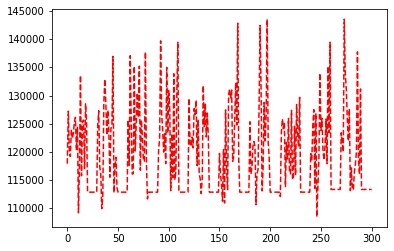

In [5]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [6]:
Q = loadQ()
Q

id                                               path    Q  \
0        0                                                [0]  0.0   
1        1                                            [0, 33]  0.0   
2        2                                        [0, 33, 41]  0.0   
3        3                                    [0, 33, 41, 25]  0.0   
4        4                                [0, 33, 41, 25, 28]  0.0   
...    ...                                                ...  ...   
8359  8359  [0, 50, 33, 41, 25, 28, 0, 42, 36, 35, 47, 29,...  0.0   
8360  8360  [0, 50, 33, 41, 25, 28, 0, 42, 36, 35, 47, 29,...  0.0   
8361  8361  [0, 50, 33, 41, 25, 28, 0, 42, 36, 35, 47, 29,...  0.0   
8362  8362  [0, 50, 33, 41, 25, 28, 0, 42, 36, 35, 47, 29,...  0.0   
8363  8363  [0, 50, 33, 41, 25, 28, 0, 42, 36, 35, 47, 29,...  0.0   

                                                   next  lastval  
0     [1, 110, 421, 577, 1200, 1259, 1643, 1837, 224...        0  
1     [2, 907, 1036, 1482, 1702, 4911, 5143, 5201, 5...       33  
2     [3, 479, 1425, 2580, 3178, 3339, 4461, 4716, 5...       41  
3     [4, 765, 1317, 2524, 2847, 3122, 3396, 5377, 5...       25  
4                                 [5, 2405, 5567, 6938]       28  
...                                                 ...      ...  
8359                                             [8360]       22  
8360                                             [8361]       23  
8361                                             [8362]       26  
8362                                             [8363]       24  
8363                                                 []        0  

[8364 rows x 5 columns]

In [11]:
print("Episode : "+str(episode))
print("Hack : "+str(c_hacklearn)+" "+str(cek))
for m in range(route - 1):
    cap = 0
    for j in croute[m]:
        cap+=demand[j[1]]
    print("Rute "+str(m)+" : "+str(croute[m])+" -> "+str(cap))
    
print("Total Distace : "+str(total_dis))
print("-------------------------")

Episode : 301
Hack : 1 True
Rute 0 : [[0, 33], [33, 41], [41, 25], [25, 28], [28, 5], [5, 0]] -> 207
Rute 1 : [[0, 42], [42, 36], [36, 35], [35, 47], [47, 29], [29, 43], [43, 44], [44, 0]] -> 242
Rute 2 : [[0, 49], [49, 16], [16, 17], [17, 4], [4, 39], [39, 15], [15, 0]] -> 228
Rute 3 : [[0, 37], [37, 38], [38, 40], [40, 14], [14, 32], [32, 7], [7, 13], [13, 0]] -> 204
Rute 4 : [[0, 18], [18, 19], [19, 20], [20, 8], [8, 3], [3, 1], [1, 2], [2, 0]] -> 238
Rute 5 : [[0, 46], [46, 45], [45, 30], [30, 31], [31, 11], [11, 0]] -> 201
Rute 6 : [[0, 9], [9, 24], [24, 34], [34, 12], [12, 6], [6, 0]] -> 241
Rute 7 : [[0, 23], [23, 27], [27, 22], [22, 10], [10, 21], [21, 26], [26, 50], [50, 0]] -> 248
Rute 8 : [[0, 48], [48, 0]] -> 66
Total Distace : 113291.0
-------------------------
